In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import openpathsampling.storage as st

storage = st.AnalysisStorage("mstis.nc")

In [2]:
len(storage.steps)

101

In [3]:
mstis = storage.networks.load(0)
retis = mstis.sampling_transitions[0]
scheme = storage.schemes[0]

### Defining labels

Everything is actually done in terms of ensembles. We can map the ensembles to any labels. In our case, we use the initial replica ID associated with the ensemble. We use this as both the numeric and string label.

In [4]:
sset0 = storage.samplesets[0]
numeric_labels = { s.ensemble : s.replica for s in sset0}
string_labels = { s.ensemble : str(s.replica) for s in sset0 }
numeric_to_string = { numeric_labels[e] : string_labels[e] for e in numeric_labels.keys()}

## Trace of ensemble visited by a replica

In the plot below, you'll see we set the labels on the axis as sset0[e].replica, so we use the replica ID associated with the ensemble in the first timestep.

In [5]:
%%time
trace_1 = paths.trace_ensembles_for_replica(0, storage.steps)

CPU times: user 2.89 ms, sys: 1.6 ms, total: 4.48 ms
Wall time: 6.69 ms


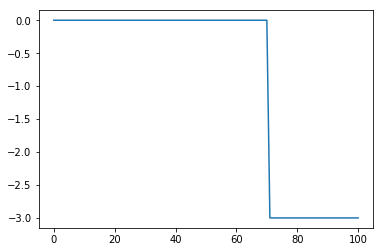

In [6]:
plt.plot([numeric_labels[e] for e in trace_1])

### Replica flow

In [10]:
repx_net = paths.ReplicaNetwork(scheme, storage.steps)

In [11]:
flow = repx_net.flow(bottom=retis.minus_ensemble, top=retis.ensembles[-1])
print(flow)

{<openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x11aad4dd0>: 1.0, <openpathsampling.ensemble.TISEnsemble object at 0x11a8757d0>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x11aa9fd90>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x11aabba50>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x11a875f90>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x11a875790>: 0.01818181818181818, <openpathsampling.ensemble.TISEnsemble object at 0x11aacc3d0>: 0.989247311827957, <openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x11aaa8990>: 0.0, <openpathsampling.ensemble.UnionEnsemble object at 0x11aac4a50>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x11aa9ffd0>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x11aa96f90>: 0.0, <openpathsampling.ensemble.MinusInterfaceEnsemble object at 0x11a883f10>: 0.0, <openpathsampling.ensemble.TISEnsemble object at 0x11aa968d0>: 0.0}


In [12]:
flow_num = {numeric_labels[k] : flow[k] for k in flow.keys()}
print(flow_num)

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.989247311827957, 7: 0.01818181818181818, 8: 0.0, 9: 0.0, -2: 0.0, -3: 0.0, -1: 1.0}


In [13]:
sorted_vals = []
for k in sorted(flow_num.keys()):
    sorted_vals.append(flow_num[k])

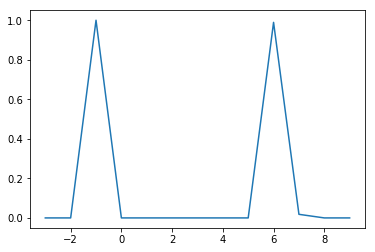

In [14]:
plt.plot(sorted(flow_num.keys()), sorted_vals)

### Trips

Now we calculate "up" trips, "down" trips, and round-trips.

In [15]:
repx_net.trips(bottom=retis.minus_ensemble, top=retis.ensembles[-1])

No handlers could be found for logger "openpathsampling.analysis.replica_network"


{'down': [], 'round': [], 'up': []}

### Transition matrix

The transition matrix is the (unsymmetrized) matrix of the transition probabilities. By default, it automatically sets its order from the Cuthill-McKee reverse ordering algorithm.

In [16]:
repx_net.transition_matrix().style
# .style has the effect that 0.0 is reported as 0 instead of 0.000000

,10,6,7,8,11,3,4,12,0,1,2,9,5
10,0,0.03125,0,0,0,0,0,0,0,0,0,0,0
6,0.03125,0,0.0625,0,0,0,0,0,0,0,0,0,0
7,0,0.0625,0,0.03125,0,0,0,0,0,0,0,0,0
8,0,0,0.03125,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0.03125,0,0,0,0,0,0,0
3,0,0,0,0,0.03125,0,0.03125,0,0,0,0,0,0
4,0,0,0,0,0,0.03125,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0.09375,0,0,0,0
0,0,0,0,0,0,0,0,0.09375,0,0.03125,0,0,0
1,0,0,0,0,0,0,0,0,0.03125,0,0.03125,0,0


If you would like to set a different order, that can be done by providing a list of the ensembles in whatever order you choose:

In [17]:
import numpy as np
perm = np.random.permutation(len(mstis.all_ensembles))
print(perm)

[11  8  1  2  4  6  7  3  9  0 10 12  5]


In [18]:
order = [mstis.all_ensembles[p] for p in perm]
repx_net.transition_matrix(index_order=order).style

,11,8,1,2,4,6,7,3,9,0,10,12,5
11,0,0,0,0,0,0,0,0.03125,0,0,0,0,0
8,0,0,0,0,0,0,0.03125,0,0,0,0,0,0
1,0,0,0,0.03125,0,0,0,0,0,0.03125,0,0,0
2,0,0,0.03125,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0.03125,0,0,0,0,0
6,0,0,0,0,0,0,0.0625,0,0,0,0.03125,0,0
7,0,0.03125,0,0,0,0.0625,0,0,0,0,0,0,0
3,0.03125,0,0,0,0.03125,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0.03125,0,0,0,0,0,0,0,0,0.09375,0


### Mixing matrix

Same as the transition matrix $T$, but $\frac{1}{2}(T+T^T)$.

In [19]:
repx_net.mixing_matrix().style

,10,6,7,8,11,3,4,12,0,1,2,9,5
10,0,0.03125,0,0,0,0,0,0,0,0,0,0,0
6,0.03125,0,0.0625,0,0,0,0,0,0,0,0,0,0
7,0,0.0625,0,0.03125,0,0,0,0,0,0,0,0,0
8,0,0,0.03125,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0.03125,0,0,0,0,0,0,0
3,0,0,0,0,0.03125,0,0.03125,0,0,0,0,0,0
4,0,0,0,0,0,0.03125,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0.09375,0,0,0,0
0,0,0,0,0,0,0,0,0.09375,0,0.03125,0,0,0
1,0,0,0,0,0,0,0,0,0.03125,0,0.03125,0,0


### Making a pretty picture

In [20]:
repxG = paths.ReplicaNetworkGraph(repx_net)

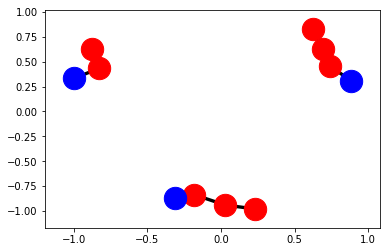

In [21]:
# draw('graphviz') gives better results, but requires pygraphviz
repxG.draw('spring')

Blue is a minus interface, red is a normal interface. Multiple state outer interfaces (not in this example) would be green.

### Alternate way of calculating transitions

There's another, perhaps better, way to calculate transitions. This does double count, but doesn't care if the how the transition happened (only that it did).

In [22]:
transitions = repx_net.transitions_from_traces(storage.steps)

In [23]:
for (k1, k2)  in transitions.keys():
    print("{} {} {}".format(numeric_labels[k1], numeric_labels[k2], transitions[(k1, k2)]))

1 2 1
-2 3 1
4 3 1
-1 6 3
-3 0 1
7 8 1
2 1 1
6 -1 3
1 0 2
3 4 1
3 -2 1
7 6 1
6 7 1
0 1 2
0 -3 1
8 7 1


In [24]:
for (k1, k2) in repx_net.analysis['n_accepted'].keys():
        print("{} {} {}".format(numeric_labels[k1], numeric_labels[k2], repx_net.analysis['n_accepted'][(k1, k2)]))

1 2 1
-2 3 1
4 3 1
-1 6 3
2 1 1
7 8 1
6 -1 3
3 4 1
3 -2 1
7 6 1
1 0 2
6 7 1
-3 0 1
0 1 2
0 -3 1
8 7 1
